In [24]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 12, 6

# Loading data

In [2]:
# We use map and reduce with hadoop to aggregate the rating data in Rating.csv into Rating_generated.txt
# Here we transform .txt to .csv file for the convenience of hereafter analysis

with open('data/Rating_generated.txt') as file:
    lines = file.readlines()
    with open('data/Rating_generated.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter = ',')
        csv_writer.writerow(['teleplay_id', 'latest_rating'])
        for line in lines:
            line_list = line.split(',')
            id_raw = line_list[0].strip()
            tele_id = id_raw[2:len(id_raw)-1]
            rating_raw = line_list[1].strip()
            rating = rating_raw[0:len(rating_raw)-1]
            csv_writer.writerow([tele_id, rating])

!dir data

New_Teleplay.csv  Rating_generated.csv	Teleplay.csv
Rating.csv	  Rating_generated.txt


In [8]:
dataset = pd.read_csv('data/Teleplay.csv').fillna('').describe()

test_data = pd.read_csv('data/New_Teleplay.csv').fillna("")

new_feature_data = pd.read_csv('data/Rating_generated.csv').fillna("")

# new_feature_data.shape

# new_feature_data.head()

# Feature Enigneering

In [5]:
def preProcessing(dataset, isTrain):
    
    # For name, we simply drop it.
    # Though I still think name can be useful by using a semantics mapping or sth
    dataset = dataset.drop(columns = ['name'])
    genre_set = set()
    type_set = set()
    rows_drop = []
    for index in dataset.index:
    # For genres, we first get the summation of each genere, drop those genre rarely appeared.
    # Then we also use dummy variables to transform it into multiple variables.
        if(dataset['genre'][index] != ""):
            genres = dataset['genre'][index].split(",")
            for ge in genres:
                ge = ge.strip()
                if(ge not in genre_set):
                    dataset[ge] = 0
                dataset[ge][index] = 1
                genre_set.add(ge)
# For type: we use a dummy coding method. Generate three more columns, including short, medium, long, special, music, and ona columns
        if(dataset['type'][index] != ""):
            typ = dataset['type'][index]
            typ = typ.strip()
            if(typ not in type_set):
                dataset[typ] = 0
            dataset[typ][index] = 1
            type_set.add(typ)

        # For episodes, we tentatively do not change into a bin-interval data.
        # However, in the future version we can do this for realistic consideration, since we often have long episodes, short episodes etc.
        if(dataset['episodes'][index] == "Unknown"):
            dataset.loc[index, 'episodes'] = 0 # treat unknow as 0
        # if the dataset is for training, we drop all the entries without rating
        if(dataset['rating'][index] == ""):
            if(isTrain):
                rows_drop.append(index)
            else:
                dataset.loc[index, 'rating'] = -1

    dataset = dataset.drop(rows_drop)
    dataset['episodes'] = pd.to_numeric(dataset['episodes'])
    dataset['rating'] = pd.to_numeric(dataset['rating'])

    # For members, we check the minimum and maximum of it
    print('members min', dataset['members'].min(), 'member max', dataset['members'].max())
        

    dataset = dataset.drop(columns = ['genre'])
    dataset = dataset.drop(columns = ['type'])
    # print(genre_dict)
    return dataset

dataset = preProcessing(dataset, True)
test_data = preProcessing(test_data, False)
# dataset.shape


/home/xuxiaochuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/xuxiaochuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
members min 13 member max 1013917
members min 12 member max 793665


In [6]:
dataset.describe()

,teleplay_id,episodes,rating,members,Drama,Romance,School,Supernatural,long,Action,...,Martial Arts,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Restricted,Yaoi,Yuri
count,10011.000000,10011.000000,10011.000000,1.001100e+04,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,...,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000
mean,13724.133853,12.316452,6.474365,1.827929e+04,0.162521,0.116971,0.097792,0.083109,0.192488,0.228848,...,0.022475,0.019678,0.025971,0.006393,0.055539,0.130856,0.004195,0.093098,0.003296,0.003596
std,11234.834388,47.910410,1.026867,5.503821e+04,0.368947,0.321402,0.297049,0.276060,0.394274,0.420112,...,0.148231,0.138899,0.159058,0.079704,0.229041,0.337260,0.064639,0.290584,0.057322,0.059862
min,1.000000,0.000000,1.670000,1.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3464.500000,1.000000,5.880000,2.200000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10039.000000,2.000000,6.570000,1.507000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23827.000000,12.000000,7.180000,9.435000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,34519.000000,1818.000000,9.600000,1.013917e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Incorporate new feature by Map and Reduce

In [8]:
# we use left merge since some of the data may not have the latest rating, we treat the missing value as the average to represent "unknown"

data_merge = pd.merge(dataset, new_feature_data,on="teleplay_id", how='left').fillna(new_feature_data['latest_rating'].mean())
test_data_merge = pd.merge(test_data, new_feature_data, on='teleplay_id', how='left').fillna(new_feature_data['latest_rating'].mean())

data_merge.shape
# test_data_merge.tail()

(10011, 53)

# Traning and Testing Using Linear Regression

In [9]:
# Train set, test set spliting and normailzation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


y = data_merge['rating'].to_numpy()
X = data_merge.drop(columns=['rating','teleplay_id']).to_numpy()
test_data_X = test_data_merge.drop(columns=['rating','teleplay_id']).to_numpy()

# fit scaler on training data
norm = MinMaxScaler().fit(X)

# transform training data
X_norm = norm.transform(X)

# transform testing data
normX_test = MinMaxScaler().fit(test_data_X)
test_data_X_norm = normX_test.transform(test_data_X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [10]:
class LinearRegressionUsingGD:
    """Linear Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model
    bias_ : bias / after fitting the model
    cost_ : total error of the model after each iteration
    """

    def __init__(self, eta=0.001, n_iterations=20000):
        self.eta = eta
        self.n_iterations = n_iterations

    def fit(self, x, y, x_test, y_test):

        self.cost_ = []
        self.cost_test = []
        self.w_ = np.zeros((x.shape[1], 1))
        self.bias_ = np.zeros((1, 1))
        m = x.shape[0]

        for _ in range(self.n_iterations):
            # print(x.shape, self.w_.shape)
            y_pred = np.dot(x, self.w_) + self.bias_
            y_test_pred = np.dot(x_test, self.w_) + self.bias_
            residuals = np.subtract(y_pred,y.reshape(len(y),1))
            residuals_test = np.subtract(y_test_pred,y_test.reshape(len(y_test),1))
            gradient_vector_weight = np.dot(x.T, residuals)
            gradient_vector_bias = np.sum(residuals)
            # print(gradient_vector_weight.shape) 
            self.w_ -= (self.eta / m) * gradient_vector_weight
            self.bias_ -= (self.eta / m) * gradient_vector_bias
            cost = np.sum((residuals ** 2)) / (2 * m)
            cost_test = np.sum((residuals_test ** 2)) / (2 * m)
            self.cost_.append(cost)
            self.cost_test.append(cost_test)
        return self

    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.w_) + self.bias_

Final Root mean squared error of train set:  0.5133194900529148
Final Root mean squared error of test set:  0.49403044836488424


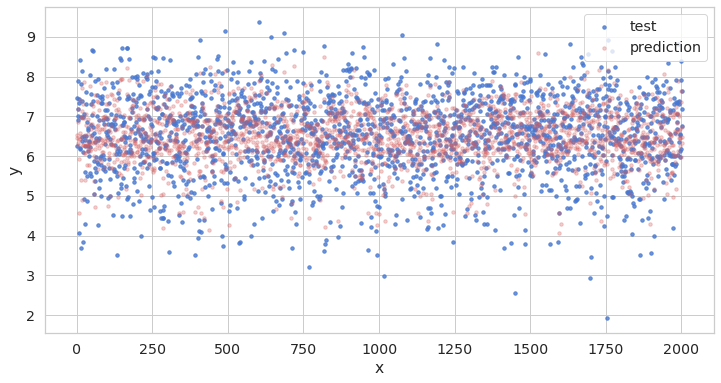

In [37]:
# Using linear regression to train model and predict
from sklearn.metrics import mean_squared_error, r2_score


reg = LinearRegressionUsingGD().fit(X_train, y_train, X_test, y_test)

y_train_pred = reg.predict(X_train)

rmse = mean_squared_error(y_train_pred, y_train)
print('Final Root mean squared error of train set: ', rmse)

y_test_pred = reg.predict(X_test)

rmse = mean_squared_error(y_test_pred, y_test)
print('Final Root mean squared error of test set: ', rmse)

x = np.arange(1, len(y_test_pred)+1)

# plot
plt.figure(figsize=(12,6))
plt.scatter(x,y_test,alpha=0.8,s=12)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y_test_pred, color='r', alpha=0.3,s=12)
plt.legend(["test", "prediction"], loc="upper right")
plt.savefig("linear.png")





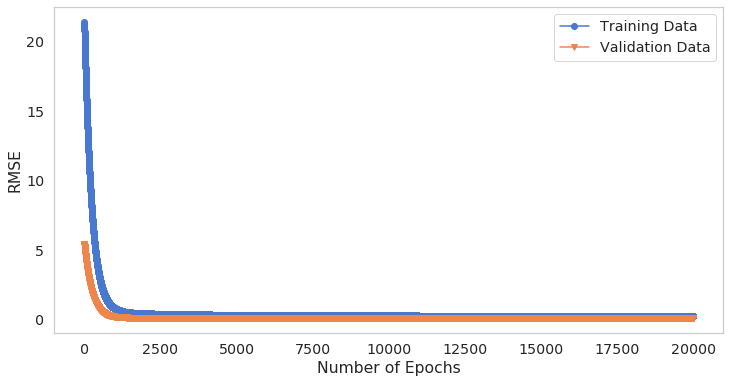

In [12]:
plt.figure(figsize=(12,6))
plt.plot(range(reg.n_iterations), reg.cost_, marker='o', label='Training Data')
plt.plot(range(reg.n_iterations), reg.cost_test, marker='v', label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.savefig("linear_curves.png")
plt.show()

In [13]:
#import new teleplay.csv

test_y_pred = reg.predict(test_data_X_norm)
test_y_pred = test_y_pred.reshape(len(test_y_pred),)

test_data = pd.read_csv('data/New_Teleplay.csv').fillna("")

test_data['rating'] = test_y_pred

test_data.to_csv("17082834d_task1_final.csv")

# Training and Testing Using Nerual Networks

Final Root mean squared error of train set:  0.3871206141482198


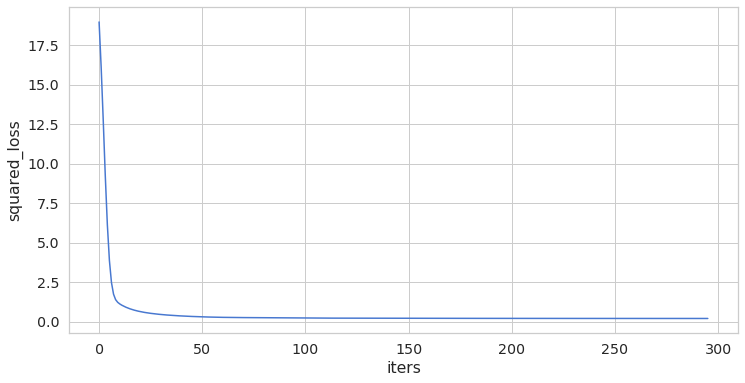

mean absolute error of test set: 0.4420717146474156
mean squared error of test set: 0.40236967352906045
R^2 of train set: 0.6359743706040513
R^2 of test set 0.6041568941071523


In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

mlpr = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
beta_2=0.999, early_stopping=False, epsilon=1e-08,
hidden_layer_sizes=(6,), learning_rate='constant',
learning_rate_init=0.001, max_iter=300, momentum=0.9,
n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
random_state=None, shuffle=True, solver='adam', tol=0.0001,
validation_fraction=0.1, verbose=False, warm_start=False).fit(X_train, y_train)

y_train_pred = mlpr.predict(X_train)

rmse = mean_squared_error(y_train_pred, y_train)
print('Final Root mean squared error of train set: ', rmse)

# x = np.arange(1, len(y_test_pred)+1)

# plot
# plt.figure(figsize=(12,6))
# plt.scatter(x,y_test,alpha=0.8,s=12)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.scatter(x, y_test_pred, color='r', alpha=0.3,s=12)
# plt.legend(["test", "prediction"], loc="upper right")
# plt.savefig("linear.png")
plt.figure()
plt.plot(mlpr.loss_curve_)
plt.xlabel("iters")
plt.ylabel(mlpr.loss)
plt.savefig("mlp.png")
plt.show()

## 对测试集上进行预测
y_test_pred = mlpr.predict(X_test)
print("mean absolute error of test set:", metrics.mean_absolute_error(y_test,y_test_pred))
print("mean squared error of test set:", metrics.mean_squared_error(y_test,y_test_pred))
## 输出在测试集上的R^2
print("R^2 of train set:",mlpr.score(X_train,y_train))
print("R^2 of test set",mlpr.score(X_test,y_test))




In [40]:
#import new teleplay.csv

test_y_pred = mlpr.predict(test_data_X_norm)
test_y_pred = test_y_pred.reshape(len(test_y_pred),)

test_data = pd.read_csv('data/New_Teleplay.csv').fillna("")

test_data['rating'] = test_y_pred

test_data.to_csv("17082834d_task1_mlp_final.csv")

# Content Based Recommendation System

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def episodes_to_categories(x):
    if int(x) < 5:
        return 'short_series'
    elif int(x) > 21:
        return 'long_series'
    else:
        return 'middle_series'
    
def members_to_categories(x):
    if x < 1000:
        return 'little_crowd'
    elif x > 100000:
        return 'big_crowd'
    else:
        return 'middle_crowd'

def rating_to_categories(x):
    if x < 6:
        return 'bad_movie'
    elif x < 8 and x > 6:
        return 'normal_movie'
    else:
        return 'good_movie'

def generate_tags(series):
    tags_list = series['genre'].split(',')
    tags_list.append(series['type'])
    tags_list.append(series['episodes'])
    tags_list.append(series['rating'])
    tags_list.append(series['members'])
    return " ".join(tags_list)

data_origin = pd.read_csv('data/Teleplay.csv').dropna()

data_origin = data_origin[data_origin['episodes']!='Unknown'].reset_index(drop=True)

data_origin['members'] = data_origin['members'].map(members_to_categories)

data_origin['episodes'] = data_origin['episodes'].map(episodes_to_categories)

data_origin['rating'] = data_origin['rating'].map(rating_to_categories)



df_index_to_tags = data_origin.apply(generate_tags, axis=1)
df_index_to_tags

0       Drama  Romance  School  Supernatural long shor...
1       Action  Comedy  Historical  Parody  Samurai  S...
2       Sci-Fi  Thriller medium long_series good_movie...
3       Action  Comedy  Historical  Parody  Samurai  S...
4       Comedy  Drama  School  Shounen  Sports medium ...
                              ...                        
9812    Restricted short short_series bad_movie little...
9813    Restricted short short_series bad_movie little...
9814    Restricted short short_series bad_movie little...
9815    Restricted short short_series bad_movie little...
9816    Restricted long short_series bad_movie little_...
Length: 9817, dtype: object

In [85]:
tf_idf = TfidfVectorizer()

df_movies_tf_idf_described = tf_idf.fit_transform(df_index_to_tags)

df_movies_tf_idf_described

<9817x61 sparse matrix of type '<class 'numpy.float64'>'
	with 72399 stored elements in Compressed Sparse Row format>

In [88]:
df_tfidf_m2m = pd.DataFrame(cosine_similarity(df_movies_tf_idf_described))
df_tfidf_m2m

,0,1,2,3,4,5,6,7,8,9,...,9807,9808,9809,9810,9811,9812,9813,9814,9815,9816
0,1.000000,0.289921,0.354723,0.289921,0.418611,0.340068,0.255603,0.234760,0.140928,0.634297,...,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.188282
1,0.289921,1.000000,0.514046,1.000000,0.302812,0.486176,0.327260,0.845463,0.872795,0.344050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.354723,0.514046,1.000000,0.514046,0.224475,0.444515,0.400408,0.277034,0.319100,0.420951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.289921,1.000000,0.514046,1.000000,0.302812,0.486176,0.327260,0.845463,0.872795,0.344050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.418611,0.302812,0.224475,0.302812,1.000000,0.311282,0.293753,0.301318,0.419847,0.288076,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9812,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
9813,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
9814,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
9815,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258


In [89]:
df_index_to_id = data_origin.teleplay_id
df_index_to_id

0       32281
1       28977
2        9253
3        9969
4       32935
        ...  
9812     9316
9813     5543
9814     5621
9815     6133
9816    26081
Name: teleplay_id, Length: 9817, dtype: int64

In [90]:
df_tfidf_m2m.columns = [str(df_index_to_id[int(col)]) for col in df_tfidf_m2m.columns]
df_tfidf_m2m.index = [df_index_to_id[idx] for idx in df_tfidf_m2m.index]

In [91]:
# This is the similarity matrix of 9817 teleplays
df_tfidf_m2m

,32281,28977,9253,9969,32935,11061,820,15335,15417,4181,...,29992,26031,10368,9352,5541,9316,5543,5621,6133,26081
32281,1.000000,0.289921,0.354723,0.289921,0.418611,0.340068,0.255603,0.234760,0.140928,0.634297,...,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.045131,0.188282
28977,0.289921,1.000000,0.514046,1.000000,0.302812,0.486176,0.327260,0.845463,0.872795,0.344050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9253,0.354723,0.514046,1.000000,0.514046,0.224475,0.444515,0.400408,0.277034,0.319100,0.420951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9969,0.289921,1.000000,0.514046,1.000000,0.302812,0.486176,0.327260,0.845463,0.872795,0.344050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
32935,0.418611,0.302812,0.224475,0.302812,1.000000,0.311282,0.293753,0.301318,0.419847,0.288076,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
5543,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
5621,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258
6133,0.045131,0.000000,0.000000,0.000000,0.000000,0.000000,0.105665,0.036692,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.783258


## Find 53698's favorite teleplay

In [92]:
data_rating = pd.read_csv('data/Rating.csv')

In [158]:
data_53698 = data_rating[data_rating['user_id'] == 53698]
favorite_id = data_53698[data_53698['rating'] == data_53698['rating'].max()].teleplay_id

viewed_tele_id = data_53698[data_53698['rating'] != -1].teleplay_id

recom_id = set()
for id in favorite_id:
    if(id in df_tfidf_m2m.index):
        similar_teles = df_tfidf_m2m[str(id)].sort_values(ascending=False)[:10].index
        for similar_id in similar_teles:
            if(similar_id not in viewed_tele_id.values):
                # print(similar_id)
                recom_id.add(similar_id) 
print(recom_id)

{5252, 29831, 138, 1035, 139, 3854, 2193, 7058, 19857, 149, 7575, 30745, 3484, 21405, 2974, 16287, 23199, 8098, 1060, 1701, 8740, 9383, 32174, 30127, 1968, 30385, 3248, 19123, 5300, 4021, 2486, 7861, 32696, 27833, 27831, 25833, 32182, 17727, 325, 711, 2760, 2761, 31815, 1607, 2507, 7629, 31181, 31953, 83, 852, 17747, 33363, 1495, 32983, 474, 32730, 4189, 10718, 7647, 1248, 32481, 32997, 15719, 20969, 7785, 3947, 6124, 29163, 877, 1135, 239, 4081, 16233, 1779, 1268, 1781, 3062, 245, 31736, 3324, 5629, 5630, 3071}


In [188]:
# recom_teles = []
with open('17082834d_task2_partA.txt', 'w') as f:

    for id in recom_id:
        tele = data_origin[data_origin['teleplay_id']== id]['name'].values[0]
        f.write(tele)
        f.write('\n')
        # recom_teles.append(tele)
# recom_teles



# Collborative Based Recommendation System

In [39]:
import pandas as pd
data_rating = pd.read_csv('data/Rating.csv').drop_duplicates(subset=['user_id', 'teleplay_id'])
data_rating.shape

(7813720, 3)

In [42]:
data_53698 = data_rating[data_rating['user_id'] == 53698]
viewed_tele_id = data_53698[data_53698['rating'] != -1].teleplay_id
# data_rating = data_rating[~data_rating['teleplay_id'].isin(viewed_tele_id.values)].reset_index(drop=True)
data_rating = data_rating[data_rating['user_id']<60000].reset_index(drop=True)
data_rating = data_rating[data_rating['user_id']>52000].reset_index(drop=True)


# data_rating['teleplay_id']
data_rating.shape
# since the dataset is too large, we eliminate those data about those movies that we will not predict

(967431, 3)

In [4]:
data_rating.shape

(3042207, 3)

In [43]:
ratings_df = data_rating.pivot(index='user_id', columns='teleplay_id', values='rating')
ratings_df

teleplay_id,1,5,6,7,8,15,16,17,18,19,...,34103,34107,34119,34238,34240,34283,34324,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
52001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52003,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59996,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
59997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
ratings = ratings_df.fillna(0).values
# print(ratings.shape)


In [45]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

1.44%


In [46]:
import numpy as np
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation
train, val = train_test_split(ratings)

In [47]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [48]:
class Recommender:
  
  def __init__(self, n_epochs=100, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        print("------", epoch, "------")
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [49]:
recommender = Recommender().fit(train, val)

------ 0 ------
------ 1 ------
------ 2 ------
------ 3 ------
------ 4 ------
------ 5 ------
------ 6 ------
------ 7 ------
------ 8 ------
------ 9 ------
------ 10 ------
------ 11 ------
------ 12 ------
------ 13 ------
------ 14 ------
------ 15 ------
------ 16 ------
------ 17 ------
------ 18 ------
------ 19 ------
------ 20 ------
------ 21 ------
------ 22 ------
------ 23 ------
------ 24 ------
------ 25 ------
------ 26 ------
------ 27 ------
------ 28 ------
------ 29 ------
------ 30 ------
------ 31 ------
------ 32 ------
------ 33 ------
------ 34 ------
------ 35 ------
------ 36 ------
------ 37 ------
------ 38 ------
------ 39 ------
------ 40 ------
------ 41 ------
------ 42 ------
------ 43 ------
------ 44 ------
------ 45 ------
------ 46 ------
------ 47 ------
------ 48 ------
------ 49 ------
------ 50 ------
------ 51 ------
------ 52 ------
------ 53 ------
------ 54 ------
------ 55 ------
------ 56 ------
------ 57 ------
------ 58 ------
------ 

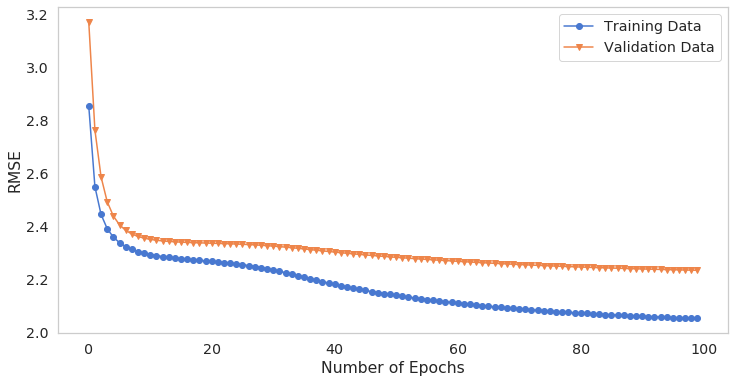

In [50]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data')
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [79]:
user_id = 53698
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)
# data_rating[data_rating['user_id']==53698]
#normalize to base 10
rating_predictions = rating_predictions / rating_predictions.max() * 10


In [80]:
def create_teleplay_ratings(teleplay_id, artists_index, ratings, n=10):
  artist_ids = ratings_df.columns[artists_index]
  artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
  top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
  artist_recommendations = teleplay_id[teleplay_id['teleplay_id'].isin(top_n_artists.artistId)].reset_index(drop=True)
  artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
  return artist_recommendations.sort_values("rating", ascending=False)

In [82]:
teleplay_df = pd.read_csv('data/Teleplay.csv',usecols=['teleplay_id','name'])

final_ratings = create_teleplay_ratings(teleplay_df, predictions_index, rating_predictions, len(predictions_index))
# teleplay_df.rating.max()
final_ratings.to_csv('17082834d_task2_partb.csv')